In [23]:
import pandas as pd
import numpy as np
import os
import torch
from tqdm import tqdm
import torchvision
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image


In [24]:
if torch.cuda.is_available():
    print("Using cuda")
    torch.set_default_device('cuda:0')

Using cuda


In [25]:
dataset_folder = "dataset"
exports_folder = "models_snapshots"
print(os.listdir(dataset_folder))

['376_1', '376_1.csv', '456_1', '456_1.csv', '456_2', '456_2.csv', '493_1', '493_1.csv', '493_2', '493_2.csv', '493_3', '493_3.csv', 'good_turns', 'good_turns.csv', 'good_turns_bog', 'good_turns_bog.csv', 'long', 'long.csv', 'long_turns', 'long_turns.csv', 'nice_race', 'nice_race.csv', 'our_fast', 'our_fast.csv', 'our_fast_short', 'our_fast_short.csv', 'our_good_driving', 'our_good_driving.csv', 'the-cones', 'the-cones.csv', 'the-red-kettle', 'the-red-kettle.csv', 'the-short', 'the-short.csv', 'the-speedy-cones', 'the-speedy-cones.csv', 'turn_left', 'turn_left.csv', 'zip_skipper', 'zip_skipper.csv']


In [26]:
X = []
y = []
folder = []

for file in os.listdir(dataset_folder):
    if not file.endswith(".csv"):
        continue

    dataset_name = file[:-4]

    data = pd.read_csv(os.path.join(dataset_folder, str(file)), header=None)

    for _, row in data.iterrows():
        img_id, forward, left = row
        img_path = os.path.join(dataset_folder, dataset_name, f"{int(img_id):04d}.jpg")
        if not os.path.exists(img_path) or forward < 0:
            continue

        X.append(img_path)
        y.append([forward, left])
        folder.append(dataset_name)
        

X = np.array(X)

y = np.array(y, dtype=np.float32)

X.shape, y.shape

((8734,), (8734, 2))

In [27]:
print(X[0], y[0])

dataset\376_1\0006.jpg [ 1.        -0.7265625]


In [28]:
batch_size = 64

In [29]:
transform = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.ToImage(), v2.ToDtype(torch.float32, scale=True), # equivalent to v2.ToTensor()
        v2.ColorJitter(brightness=0.2, contrast=0.2,),
    ]
)

In [30]:
# print unique values in the folder
print(np.unique(folder))
test_folders =['456_2', '493_2']


train_data = []
test_data = []
train_labels = []
test_labels = []
for i in range(len(X)):
    if folder[i] in test_folders:
        test_data.append(X[i])
        test_labels.append(y[i])
    else:
        train_data.append(X[i])
        train_labels.append(y[i])


['376_1' '456_1' '456_2' '493_1' '493_2' '493_3' 'good_turns'
 'good_turns_bog' 'long' 'long_turns' 'nice_race' 'our_fast'
 'our_fast_short' 'our_good_driving' 'the-cones' 'the-red-kettle'
 'the-short' 'the-speedy-cones' 'turn_left' 'zip_skipper']


In [31]:
class SteeringDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        image = read_image(img_path)
        label = self.y[idx]

        if self.transform is not None:
            image = self.transform(image)

        return image, label
    
# train_dataset = SteeringDataset(train_data, train_labels, train_transform)
# test_dataset = SteeringDataset(test_data, test_labels, test_transform)

train_dataset = SteeringDataset(train_data, train_labels, transform)
test_dataset = SteeringDataset(test_data, test_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'),)

In [32]:
# print random batch
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 224, 224]) torch.Size([64, 2])


In [33]:
model = torchvision.models.mobilenet_v3_small(weights=None)
model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, 2)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / (len(progress_bar) + 1))
    return running_loss / len(train_loader)

def test_epoch(model, test_loader, criterion):
    model.eval()
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    running_loss = 0.0
    progress_bar = tqdm(test_loader, desc='Testing', leave=False)
    with torch.no_grad():
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss / (len(progress_bar) + 1))
    return running_loss / len(test_loader)

In [38]:
learning_rate = 2e-4
criterion = torch.nn.MSELoss()
num_epochs = 15
run_name = "mobilenet_v3_small"

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    print(f"Train Loss: {train_loss}")
    test_loss = test_epoch(model, test_loader, criterion)
    print(f"Test Loss: {test_loss}")
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # save model if better loss
    os.makedirs(exports_folder, exist_ok=True)
    # save model 
    if len(test_losses) == 1 or test_losses[-1] < min(test_losses[:-1]):
        model_path = os.path.join(exports_folder, f"{run_name}_{epoch}.onnx")
        torch.onnx.export(model, torch.randn(1, 3, 224, 224), model_path, opset_version=11)
        print(f"Model saved to {model_path}")
    print(f"Epoch {epoch} Train Loss: {train_loss} Test Loss: {test_loss}")

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


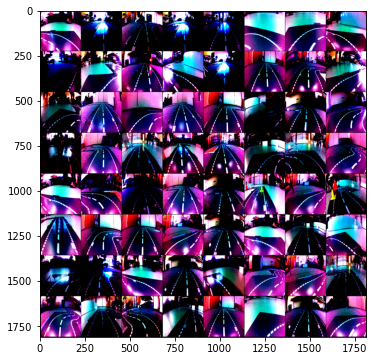

In [ ]:
with torch.no_grad():
    features, labels = next(iter(test_loader))
    # to cpu
    features = features.cpu()
    labels = labels.cpu()
    imshow(torchvision.utils.make_grid(features))